In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as t

from sklearn.model_selection import train_test_split
from torchsummary import summary

import copy 

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

labels_tensor = torch.LongTensor(data[:, 0])
data = data[:, 1:]
data_norm = data / np.max(data)
data_norm_tensor = torch.FloatTensor(data_norm.reshape(data_norm.shape[0], 1, 28, 28))

train_data, test_data, train_labels, test_labels = train_test_split(data_norm_tensor, labels_tensor, test_size=0.1, random_state=17)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 32
mnist_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(test_data, batch_size=len(test_data))

In [3]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 10, 5, 1, 1)
            self.b_norm1 = nn.BatchNorm2d(10)
            # (28 + 2*1 - 5)/1 + 1 = 26/2 = 13
            
            self.conv2 = nn.Conv2d(10, 20, 5, 1, 1)
            self.b_norm2 = nn.BatchNorm2d(20)
            # (13 + 2*1 - 5)/1 + 1 = 11/2 = 5
            
            self.fc1 = nn.Linear(5*5*20, 100)
            
            self.fc2 = nn.Linear(100, 50)
            
            self.out = nn.Linear(50, 10)
            
        def forward(self, x):
            
            x = self.conv1(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm1(x)
            x = f.leaky_relu(x)
            
            x = self.conv2(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm2(x)
            x = f.leaky_relu(x)
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            
            x = self.fc1(x)
            x = f.leaky_relu(x)
            
            x = self.fc2(x)
            x = f.leaky_relu(x)
            
            x = self.out(x)
            x = f.relu(x)
            
            return x
    
    cnn = CNN()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)
    
    return cnn, loss_fun, optimizer

In [4]:
summary(model()[0].to("cuda:0"), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
       BatchNorm2d-2           [-1, 10, 13, 13]              20
            Conv2d-3           [-1, 20, 11, 11]           5,020
       BatchNorm2d-4             [-1, 20, 5, 5]              40
            Linear-5                  [-1, 100]          50,100
            Linear-6                   [-1, 50]           5,050
            Linear-7                   [-1, 10]             510
Total params: 61,000
Trainable params: 61,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.23
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


In [5]:
x, y = next(iter(mnist_test_loader))

print(x.shape, y.shape)
y_hat = model()[0](x)
print(y_hat.shape)

torch.Size([2000, 1, 28, 28]) torch.Size([2000])
torch.Size([2000, 10])


In [6]:
def train_model(cnn, loss_fun, optimizer, device, train_loader, test_loader, num_epochs = 20):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        cnn.train()
        batch_loss = []
        batch_acc = []
        
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_hat = y_hat.cpu()
            y = y.cpu()
            
            batch_loss.append(loss.item())
            batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
            
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        cnn.eval()
        
        x, y = next(iter(test_loader))
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)

        y_hat = y_hat.cpu()
        y = y.cpu()
        
        test_loss.append(loss.item())
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
    
    return train_acc, train_loss, test_acc, test_loss, cnn

In [7]:
mnist_cnn, loss_fun, optimizer = model()

train_acc, train_loss, test_acc, test_loss, cnn = train_model(mnist_cnn, loss_fun, optimizer, "cpu", mnist_train_loader, mnist_test_loader)

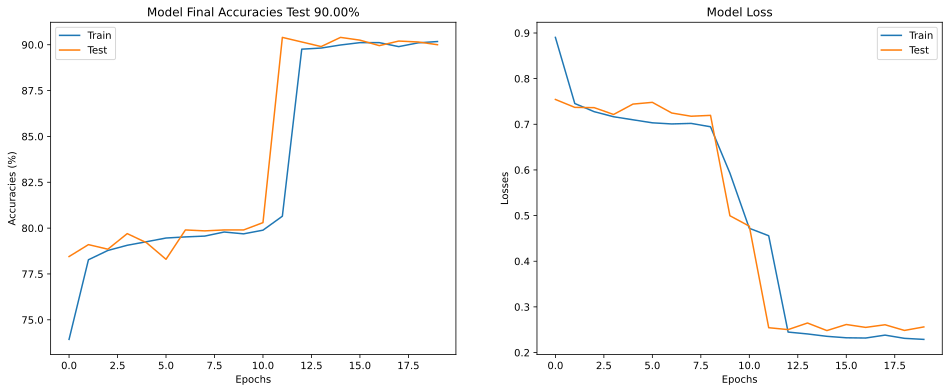

In [8]:
_, axis = plt.subplots(1, 2, figsize=(16, 6))

axis[0].plot(train_acc, "-", label="Train")
axis[0].plot(test_acc, "-", label="Test")
axis[0].set_title(f"Model Final Accuracies Test {test_acc[-1]:0.2f}%")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].legend()

axis[1].plot(train_loss, "-", label="Train")
axis[1].plot(test_loss, "-", label="Test")
axis[1].set_title("Model Loss")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].legend();

In [9]:
transformations = t.Compose([t.ToTensor(), t.Normalize(.5,.5)])

train_set = torchvision.datasets.FashionMNIST(root="data", train=True, download=True, transform=transformations)
test_set = torchvision.datasets.FashionMNIST(root="data", train=False, download=True, transform=transformations)

fashion_train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(test_set, batch_size=len(test_set))

In [10]:
x, y = next(iter(fashion_test_loader))
y_hat = cnn(x)
fashion_acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

print(f"Performance on Fashion MNIST: {fashion_acc:0.2f}")

Performance on Fashion MNIST: 12.11


In [11]:
fashion_cnn, loss_fun, optimizer = model()

print(fashion_cnn.conv1.weight[0] - mnist_cnn.conv1.weight[0])

for target, source in zip(fashion_cnn.named_parameters(), mnist_cnn.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

print(fashion_cnn.conv1.weight[0] - mnist_cnn.conv1.weight[0])

tensor([[[-0.0084,  0.0937, -0.2649, -0.1202, -0.0354],
         [ 0.1303,  0.0626,  0.1628,  0.1670,  0.0911],
         [ 0.2021, -0.1219,  0.2023,  0.1409, -0.0057],
         [-0.0588, -0.1619, -0.1283, -0.3780, -0.4976],
         [ 0.4289, -0.1825,  0.1718, -0.1252,  0.3019]]],
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SubBackward0>)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fashion_cnn.to(device)
train_acc, train_loss, test_acc, test_loss, cnn = train_model(fashion_cnn, loss_fun, optimizer, device, fashion_train_loader, fashion_test_loader, 10)

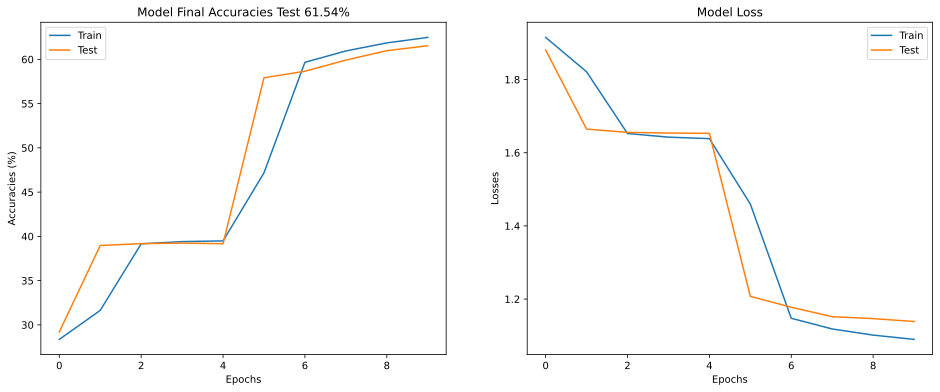

In [13]:
_, axis = plt.subplots(1, 2, figsize=(16, 6))

axis[0].plot(train_acc, "-", label="Train")
axis[0].plot(test_acc, "-", label="Test")
axis[0].set_title(f"Model Final Accuracies Test {test_acc[-1]:0.2f}%")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].legend()

axis[1].plot(train_loss, "-", label="Train")
axis[1].plot(test_loss, "-", label="Test")
axis[1].set_title("Model Loss")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].legend();